# Differentiable Physics Model: Lorenz 96


In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [9]:
import pytreeclass as pytc
import jax.numpy as jnp
import jax
from jax.experimental.ode import odeint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from lib._src.dynamical.base import DynamicalSystem
from lib._src.dynamical.l96 import Lorenz96

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dynamical System

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\frac{dx}{dt} = (x_{i+1} - x_{i-2})x_{i-1}-x_i+F
$$

where $F$ is normally 8 to cause some chaotic behaviour.

In [10]:
grid_size = 50
F = 8
dt = 0.01
t0 = 0.0
t1 = 30.0
observe_every = 10
n_steps = len(jnp.arange(t0, t1, dt)) 


# define dynamical system
model = Lorenz96(
    dt=dt, grid_size=grid_size, 
    observe_every=observe_every, F=F
)

# initialize trajectory
x0 = model.init_x0(0.01)

# perform integration (warmup)
x_warmup = model.warmup(x0, n_steps)
assert x_warmup.shape == (grid_size,)

# perform integration
x, t = model.integrate(x_warmup, n_steps)
assert x.shape == (n_steps, grid_size)

# do observation operator
y, t_obs = model.observe(x, n_steps)

In [11]:
t.min(), t.max(), t_obs.min(), t_obs.max()

(Array(0., dtype=float32),
 Array(29.99, dtype=float32),
 Array(0., dtype=float32),
 Array(29.9, dtype=float32))

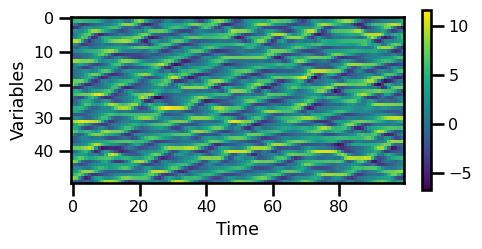

In [12]:
fig, ax = plt.subplots(figsize=(5,3))

pts = ax.imshow(y[-100:].T)
fig.colorbar(pts, cmap="viridis", fraction=0.025)
ax.set_xlabel("Time")
ax.set_ylabel("Variables")
plt.tight_layout()
plt.show()

In [13]:
import jax.random as jrandom

key = jrandom.PRNGKey(seed=123)



In [14]:
grid_size = 50
n_batches = 32
F = 8
dt = 0.01
t0 = 0.0
t1 = 30.0
observe_every = 10
n_steps = len(jnp.arange(t0, t1, dt)) 
n_warmup_steps = 1000


# define dynamical system
model = Lorenz96(
    dt=dt, grid_size=grid_size, 
    observe_every=observe_every, F=F
)

# initialize batch
x0 = model.init_x0_batch(n_batches, 0.01)


# perform integration (warmup, batches)
x_warmup = model.batch_warmup(x0, n_warmup_steps)
assert x_warmup.shape == (n_batches, grid_size)

# perform integration (batches)
x, t = model.batch_integrate(x_warmup, n_steps)
assert x.shape == (n_batches, n_steps, grid_size)

# do observation operator
y, t_obs = model.batch_observe(x, n_steps)


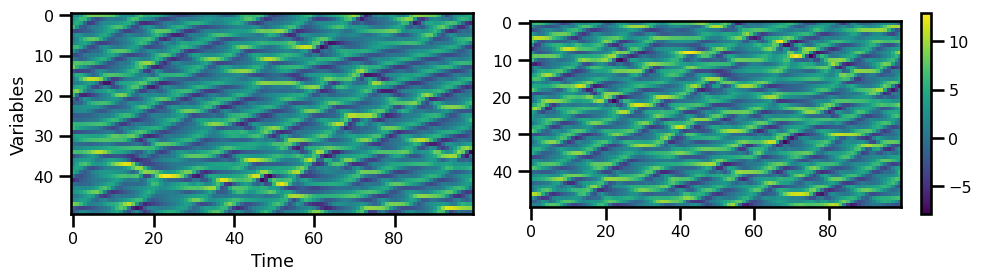

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pts = ax[0].imshow(y[100, -100:].T)

pts = ax[1].imshow(y[30, -100:].T)
plt.colorbar(pts, cmap="viridis", fraction=0.025)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Variables")
plt.tight_layout()
plt.show()